In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

In [12]:
file_path = os.path.join(os.environ.get('prodir'),'waom10_tds_2015.nc')
min_t = xr.open_dataset(file_path)
file_path = os.path.join(os.environ.get('prodir'),'waom10_tds_2024.nc')
max_t = xr.open_dataset(file_path)
file_path = os.path.join(os.environ.get('prodir'),'waom10_tds_2019.nc')
mean_t = xr.open_dataset(file_path)

In [6]:
print(min_t.tidal_constituents.values)

[[b'M' b'S' b'N' b'K' b'K' b'O' b'P' b'Q' b'M' b'M' b'M' b'M' b'M']
 [b'2' b'2' b'2' b'2' b'1' b'1' b'1' b'1' b'F' b'M' b'4' b'S' b'N']
 [b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b'4' b'4']
 [b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ' b' ']]


In [30]:
mean_t.tide_Eamp

<xarray.DataArray 'tide_Eamp' (tide_period: 13, eta_rho: 530, xi_rho: 630)>
[4340700 values with dtype=float64]
Coordinates:
  * tide_period  (tide_period) timedelta64[ns] 0 days 12:25:14.163600 ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  tidal elevation amplitude
    units:      meter
    field:      tide_Eamp, scalar

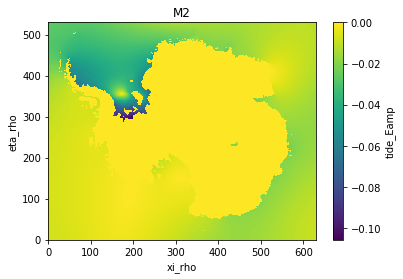

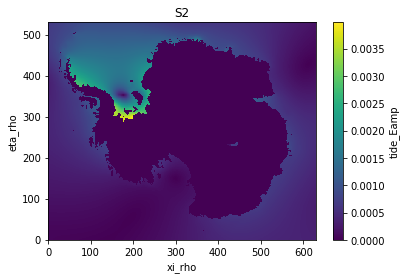

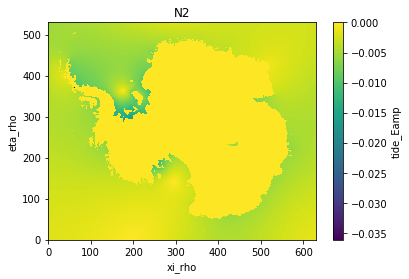

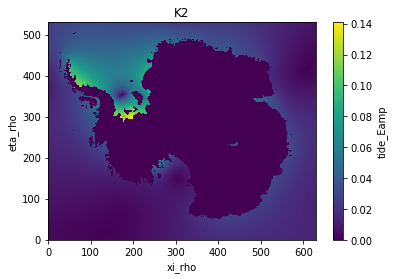

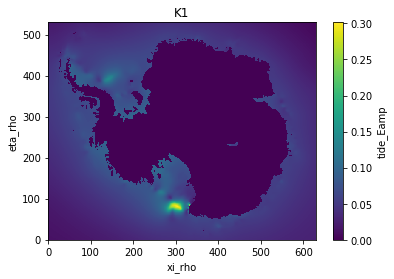

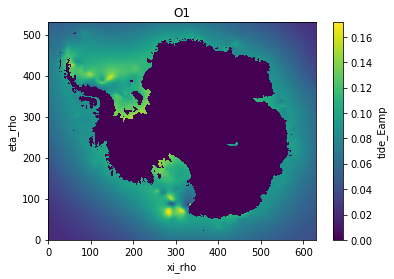

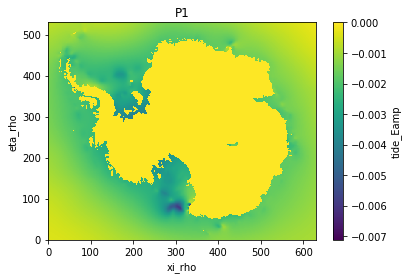

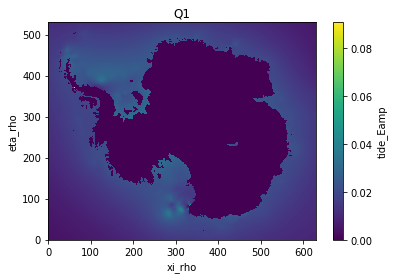

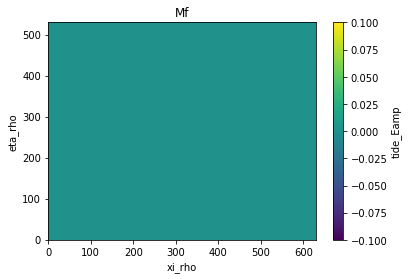

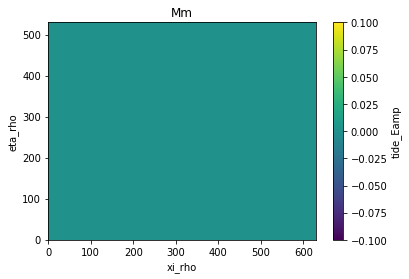

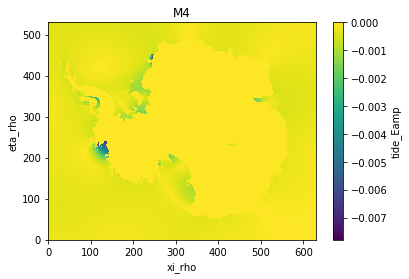

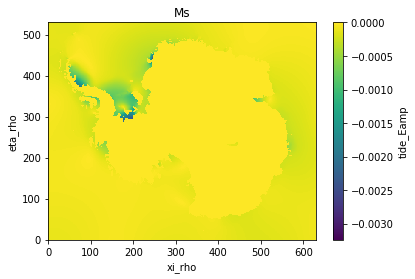

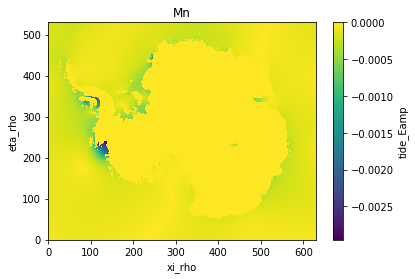

In [33]:
plt.close()
for ind,const in enumerate(['M2','S2','N2','K2','K1','O1','P1','Q1','Mf','Mm','M4','Ms','Mn']):
    (max_t.tide_Eamp[ind] - min_t.tide_Eamp[ind]).plot()
    plt.title(const)
    plt.show()